# Setup

In [5]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import specific components from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# enhanced stats functions
from scipy import stats

# for ease of data profiling
from pandas_profiling import ProfileReport

In [6]:
# print environment setup details
print(f"pandas version  : {pd.__version__}")  # 1.4.3
print(f"numpy version   : {np.__version__}")  # 1.23.1
print(f"seaborn version : {sns.__version__}") # 0.11.2

pandas version  : 1.4.2
numpy version   : 1.22.3
seaborn version : 0.11.2


Here, we also set the seed for numpy's random number generator such that our results are fully reproducible. This is because the other libraries (e.g. scikit-learn) use this random number generator, so if we set the seed we will always generate the same random numbers in the same sequence.

Thus, whenever we run the notebook from top-to-bottom, we will end up with the *exact* same results! 

In [7]:
SEED = 123
np.random.seed(SEED)

# Data Loading


In [8]:
# read in data
df = pd.read_csv("insurance.csv")

In [9]:
# make sure data was read in properly and matches above table
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


# EDA
**Data dictionary**

| column | data definition | 
| --- | --- | 
| age | age of insured person | 
| sex | sex of insured person, either male or female | 
| bmi | body mass index of insured person |
| children | number of dependents covered by health insurance |
| smoker | does the insured person smoke? |
| region | the insured person's residential area within the US |
| charges | medical costs billed by health insurance; target variable |

For additional information, check the dataset's [information on Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance).

In [21]:
# optional: use pandas-profiling to do quick first pass at EDA
profile = ProfileReport(df, title="Insurance Dataset Profiling Report")
# create html file to view report
profile.to_file("insurance_dataset_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# conduct any other EDA that you need to in order to get a good feel for the data
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Average age of individuals in the data set

In [11]:
# calculate median age
df['age'].median()

39.0

Index of people with the highest BMI

In [12]:
# find index of person with highest BMI
df['age'][df.bmi == df['bmi'].max()]

1317    18
Name: age, dtype: int64

Checking the correlation of data set variables

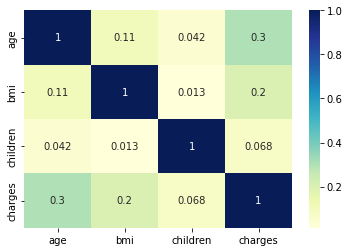

In [13]:
# plot correlation heatmap
plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Distribution of variable charges in the data set

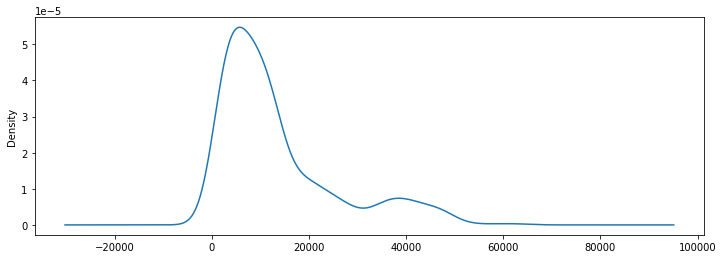

In [14]:
# plot distribution of charges
dis_ = plt.figure(figsize=(12,4))
df['charges'].plot(kind='kde')
plt.show()

It looks like the data is not distributed normally. Looks like it needs to change the data in some way to make it closer to a normal distribution.

In [15]:
# take log of charges, then drop old column
df["log_charges"] = np.log(df['charges'])
# drop charges column 
df.drop(['charges'], axis=1, inplace=True)

In [16]:
# check if your table matches the one above
df.head(2)

,age,sex,bmi,children,smoker,region,log_charges
0,19,female,27.90,0,yes,southwest,9.734176
1,18,male,33.77,1,no,southeast,7.453302


Plot the new distribution to see if it is a normal distribution.

<function matplotlib.pyplot.show(close=None, block=None)>

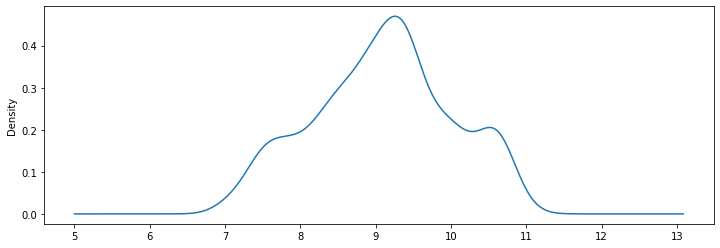

In [17]:
# plot distribution for log_charges
f = plt.figure(figsize=(12,4))
df['log_charges'].plot(kind='kde')
plt.show

Even after logging the variable charges, it's still not distributed normally. But now it's closer to a normal distribution than the original data, so can continue the analysis using this log_charges variable as the target variable instead!

Find rows that are identical to each other

In [18]:
# find indexes of duplicated rows
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,log_charges
581,19,male,30.59,0,no,northwest,7.402185


# Data Wrangling
After knowing what the data set looks like, the next step is to prepare for modeling.

In this case, it has no data to lose, so there is no need to do anything about it. We have one duplicate row, but it looks like it's legit data, so we're going to keep it.

We have 3 categorical variables - gender, smoker, and region. Get dummy variables using pandas, make sure to use arguments to reduce the possibility of multicollinearity problems.

In [19]:
# get dummies for sex, smoker, and region
df_dummies = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df_dummies

,age,bmi,children,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,9.734176,0,1,0,0,1
1,18,33.770,1,7.453302,1,0,0,1,0
2,28,33.000,3,8.400538,1,0,0,1,0
3,33,22.705,0,9.998092,1,0,1,0,0
4,32,28.880,0,8.260197,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,9.268661,1,0,1,0,0
1334,18,31.920,0,7.698927,0,0,0,0,0
1335,18,36.850,0,7.396233,0,0,0,1,0
1336,21,25.800,0,7.604867,0,0,0,0,1


Now verify that it still doesn't have a major multicollinearity problem with the heatmap. With most of the correlation between the independent variables should still be relatively low. There is no single cut-off value (much of this is art as much as it is science), but we will say for our purposes here that we will consider anything between -0.5 and 0.5 low.

Note that if the variable is highly correlated with our dependent variable, that's okay. If anything, that's probably a good thing!

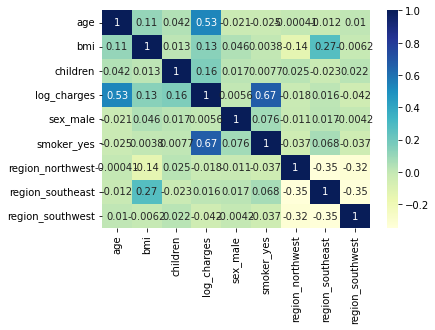

In [20]:
# correlation plot heatmap
corr_df = sns.heatmap(df_dummies.corr(), cmap="YlGnBu", annot=True)
plt.show()

The independent variable that is owned after getting the dummy variable.

In [21]:
# get number of independent variables
independent_var = []
for i in df_dummies:
    if i != 'log_charges':
        independent_var.append(i)
len(independent_var)

8

Split the independent variable into a variable called 'X', and the target variable log_charges into a variable called 'y'.

In [22]:
# split up our variables
X = df_dummies[independent_var]
y = df_dummies['log_charges']
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,1,0,1,0,0
1334,18,31.920,0,0,0,0,0,0
1335,18,36.850,0,0,0,0,1,0
1336,21,25.800,0,0,0,0,0,1


In [23]:
# the resulting shapes of X and y should be (1338, 8) and (1338,) respectively
print(X.shape)
print(y.shape)

(1338, 8)
(1338,)


Next, it is necessary to divide the data into training and testing data. Using the scikit-learn function, using 0.3 (i.e. 30% of the data in the test set), and ensuring that the random state is set to our seed from above.

Documentation for `train_test_split()` can be found here: https://scikit-learn.org/1.1/modules/generated/sklearn.model_selection.train_test_split.html

In [24]:
# do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

The index for the first five data points in the training dataset after train_test_split

In [25]:
X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
300,36,27.55,3,1,0,0,0,0
904,60,35.10,0,0,0,0,0,1
670,30,31.57,3,1,0,0,1,0
617,49,25.60,2,1,1,0,0,1
373,26,32.90,2,1,1,0,0,1


# Modelling and Evaluation
Now can make models! Instantiate the LinearRegression model in scikit-learn, then adjust it against the training data above.

Documentation for `LinearRegression()` can be found here: https://scikit-learn.org/1.1/modules/generated/sklearn.linear_model.LinearRegression.html

In [26]:
# instantiate linear regression model and fit the training data to it
lr = LinearRegression()

lr.fit(X_train,y_train)

LinearRegression()

In [27]:
# describe model
print(f"intercept: {lr.intercept_:.4f}")
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]}: {lr.coef_[i]:.4f}")

intercept: 6.9877
age: 0.0347
bmi: 0.0151
children: 0.1070
sex_male: -0.0837
smoker_yes: 1.5320
region_northwest: -0.0879
region_southeast: -0.1546
region_southwest: -0.1433


Evaluate models with some basic metrics on training data and test data (eg MAE, RMSE, R^2).

In [28]:
# predict training set values
predictions_train = lr.predict(X_train)

In [29]:
# evaluate model R^2 (score) r2_score
r2_train = r2_score(y_train, predictions_train)

In [30]:
# evaluate model MAE mean_absolute_error, 
mae_train = mean_absolute_error(y_train, predictions_train) 

In [31]:
# evaluate model RMSE  mean_squared_error,
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train)) 

In [32]:
# print metrics
print("metrics for training data")
print(f"R^2 score : {r2_train:.4f}")
print(f"mae       : {mae_train:.4f}")
print(f"rmse      : {rmse_train:.4f}")

metrics for training data
R^2 score : 0.7608
mae       : 0.2880
rmse      : 0.4557


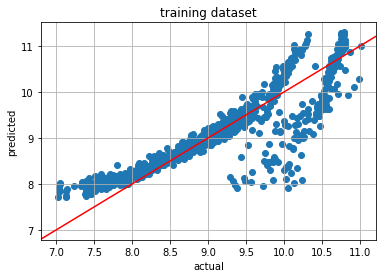

In [33]:
# plot predictions against actual values
plt.scatter(y_train, predictions_train)
plt.title("training dataset")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.gca().axline([7, 7], [11, 11], color="red")
plt.grid()

Obviously, while our model has clearly learned something about the data, there is still room for improvement.

Evaluate the performance of the model on the test set.

In [34]:
# make predictions on test set
predictions_test = lr.predict(X_test)

In [35]:
# get same metrics as before - R^2, MAE, RMSE
r2_test =  r2_score(y_test, predictions_test)
mae_test = mean_absolute_error(y_test, predictions_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

In [36]:
# print metrics
print("metrics for test data")
print(f"R^2 score : {r2_test:.4f}")
print(f"mae       : {mae_test:.4f}")
print(f"rmse      : {rmse_test:.4f}")

metrics for test data
R^2 score : 0.7841
mae       : 0.2697
rmse      : 0.4129


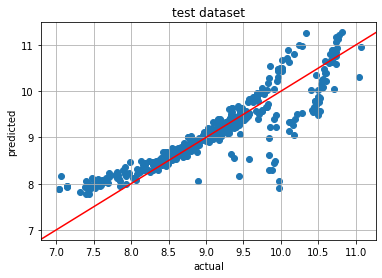

In [37]:
# plot predictions against actual values
plt.scatter(y_test, predictions_test)
plt.title("test dataset")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.gca().axline([7, 7], [11, 11], color="red")
plt.grid()

## Question 8
Are the residuals normally distributed?

<AxesSubplot:xlabel='log_charges', ylabel='Count'>

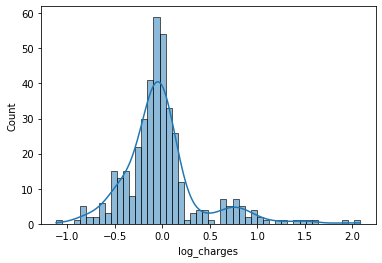

In [39]:
# plot residuals to determine if they are normally distributed
residuals = y_test - predictions_test
sns.histplot(residuals, bins=50, kde=True)
# sns.residplot(y_test, predictions_test)


We know that taking logs to make it closer to the normal distribution. While this is useful for modelling, in the end we want to predict the actual insurance costs, not log them.

Predicted insurance for index 650 (first row in the test data set), rounded to 2 decimal places (i.e. nearest penny).

In [40]:
# get predicted insurance charge for index 650
charge = lr.predict(X_test.head(1))
charge = "%.2f" % np.exp(charge)
# charge = "%.2f" % charge
charge = float(charge)
charge

11995.36

In [41]:
# get the predicted insurance charges
print(f"predicted insurance charges: {charge:.2f}")

predicted insurance charges: 11995.36


# Discussion
While our model has learned some of the relationships from the data, it is still imperfect. What else could we do to improve it? Here are some possibilities:
1. We did not normalize/standardize our data, which could result in larger numeric variables (e.g. age) having a larger impact on the final result than smaller numeric variables (e.g. children). For more on normalization and standardization, check out [this resource](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/).
2. As our region dummy variables seem somewhat negatively correlated with each other, perhaps we may have issues with multicollinearity. So we could try encoding the region variable differently, separating into just 2 variables, one for north/south and the other for east/west.
3. Perhaps some of the variables interact with each other. We could try adding additional features covering such interactions (e.g. smoking & sex, region & bmi, etc.). Check out [this resource for more information on interaction effects](https://stattrek.com/multiple-regression/interaction).
4. Instead of normalizing our `charges` value by taking the log of it, we could do a Box-Cox transformation instead. Check out [this resource for more on Box-Cox transformation](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203).


In [42]:
# replace this with your StackUp name
NAME = "S.Amri"

Name                : S.Amri
intercept           : 6.9877
age                 : 0.0347
bmi                 : 0.0151
children            : 0.1070
sex_male            : -0.0837
smoker_yes          : 1.5320
region_northwest    : -0.0879
region_southeast    : -0.1546
region_southwest    : -0.1433
------------------------
Predicted insurance charges: 11995.36


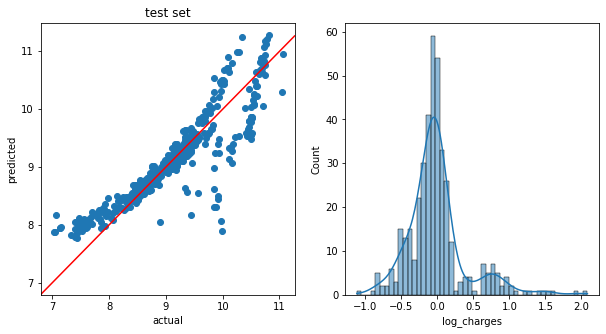

In [43]:
# run this cell, then take a screenshot of the result
print(f"{'Name':<20}: {NAME}")
# describe model
print(f"{'intercept':<20}: {lr.intercept_:.4f}")
for col in range(len(X_train.columns)):
    print(f"{X_train.columns[col]:<20}: {lr.coef_[col]:.4f}")
print("---"*8)
# get predicted insurance charge for index 650
print(f"Predicted insurance charges: {charge:.2f}")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,5)

# draw plots for test set
# ax1 - scatter plot of predictions vs actual
ax1.scatter(y_test, predictions_test)
ax1.axline([7, 7], [11, 11], color="red")
ax1.set_title("test set")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")

# ax2 - residuals plot
sns.histplot(residuals, bins=50, kde=True, ax=ax2)

plt.show()